# **Approche non supervisée**

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import Nmf

#vis
import pyLDAvis
import pyLDAvis.gensim

# Mesures de durée d'éxécution
import time

# Éviter les Deprecation Warning avec NMF
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Utilisé lors de la sauvagarde de données dans des fichiers
import pickle
import os

- Mesure de la durée d'exécution du notebook : 

In [2]:
t_notebook = time.time()

- Importations des données : 

In [3]:
with open('data_clean.pkl', 'rb') as fichier:
    data = pickle.load(fichier)

data

,corpus,tags
0,"[firebase, testing, jest, error, assertion, cl...","[jestjs, firebase, reactjs]"
1,"[block, hack, language, benefit, block, job, w...","[async-await, concurrency]"
2,"[type, function, typescript, function, type, i...",[typescript]
3,"[store, service, account, looking, expo, appli...",[expo]
4,"[store, retrieve, structure, type, c, copying,...",[c]
...,...,...
46493,"[option, option, know, option, case, option, o...","[javascript, jquery]"
46494,"[ring, plot, attempt, gap, use, plot, paint, r...","[matplotlib, python]"
46495,"[security, problem, terraform, dependency, loc...",[terraform]
46496,"[studio, creation, blob, container, error, mes...",[azure]


- Option d'échantillonages pour la réalisation de tests : 

In [4]:
echantillon = True
taille_echantillon = 5000

if echantillon:
    data = data.sample(taille_echantillon)

In [5]:
# Création d'un dictionnaire avec le vocabulaire de notre corpus
id2word = corpora.Dictionary(data['corpus'])

# Vocabulaire présent dans le corpus
print(f"Taille du dictionnaire (donc du vocabulaire de notre corpus) : {len(id2word)}")

# Création d'un corpus encodé en bag of word (bow)
corpus = []
for text in data['corpus']:
    new = id2word.doc2bow(text)
    corpus.append(new)

print("-"*50)

# Pour exemple, les 20 premiers mots (encodé en bow) du premier document de notre corpus
print(f"Premier document encodé : {corpus[0][0:20]}")

print("-"*50)

# Les 10 premiers mots du dictionnaire id2word avec leur fréquence dans le corpus
print("Les 10 premières entrées du dictionnaire (avec leur fréquences): \n")
for i in range(10):
    print(f"{id2word[i]} ({id2word.dfs[i]})")



Taille du dictionnaire (donc du vocabulaire de notre corpus) : 3341
--------------------------------------------------
Premier document encodé : [(0, 1), (1, 2), (2, 1), (3, 4), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 2), (19, 1)]
--------------------------------------------------
Les 10 premières entrées du dictionnaire (avec leur fréquences): 

advice (47)
app (401)
area (40)
blazor (29)
building (48)
cshtml (3)
directory (139)
docker (114)
endpoint (72)
error (1333)


- Tests pour déterminer le nombre de sujets qui apporte le meilleur score de cohérence (CV) : 

<div class="alert alert-info">
Le score de cohérence 'c_v' est un nombre réel qui mesure à quel point les mots à l'intérieur de chaque topic sont similaires les uns aux autres en termes de co-occurrence dans les documents. Un score de cohérence plus élevé indique des topics plus cohérents, c'est-à-dire que les mots à l'intérieur d'un topic ont tendance à apparaître ensemble dans les documents. Il permet d'évaluer la qualité d'un modèle de topic modeling (ici LDA). Plus le score de cohérence est élevé, meilleure est la cohérence des topics.
</div>

In [6]:
# Les tests étant très longs, ne les lançons pas à chaque exécution du notebook
do_test = False

if do_test:

    tests_results_lda = {}

    for i in range(0, 201, 5):

        num_topics_lda = i

        # Il faut au moins un sujet
        if i == 0:
            num_topics_lda = i + 1

        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics_lda,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha="auto")
        
        coherence_model = CoherenceModel(model=lda_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

        coherence_score = coherence_model.get_coherence()

        tests_results_lda[lda_model.num_topics] = coherence_score

        print(f"{lda_model.num_topics} topics : {coherence_score:.4f}")

    nom_fichier = 'num_topics_lda'
    # Export du dataset data
    if os.path.isfile(f'{nom_fichier}.pkl') == False:
        with open(f'{nom_fichier}.pkl', 'wb') as fichier:
            pickle.dump(tests_results_lda, fichier)
        print(f"Fichier {nom_fichier}.pkl créé.")
    else:
        print(f"Le fichier {nom_fichier}.pkl existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")

- Résultats : 

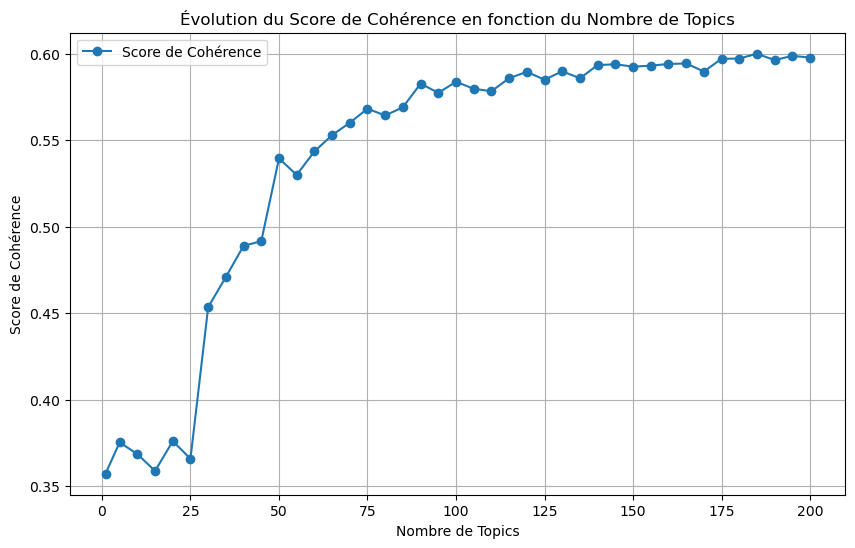

In [7]:
# Chargement des données provenant des tests réalisés (sur échantillon de 5000): 
with open('num_topics_lda.pkl', 'rb') as fichier:
    tests_results = pickle.load(fichier)

# Réprésentation graphique des résultats : 

num_topics = list(tests_results.keys())
coherence_scores = list(tests_results.values())

# Créer un graphique à l'aide de matplotlib
plt.figure(figsize=(10, 6))  # Définir la taille du graphique (facultatif)

# Tracer la courbe des scores de cohérence
plt.plot(num_topics, coherence_scores, marker='o', linestyle='-')

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre de Topics')
plt.ylabel('Score de Cohérence')
plt.title('Évolution du Score de Cohérence en fonction du Nombre de Topics')

# Afficher la légende (facultatif)
plt.legend(['Score de Cohérence'])

# Afficher le graphique
plt.grid(True)  # Activer la grille (facultatif)
plt.show()

- Entraînement du modèle LDA avec un nombre de topics optimal : 

In [8]:
# On choisit un nombre de topics parmis ceux avec les meilleurs scores de cohérence
num_topics_lda = 100

debut = time.time()  # Heure de début du traitement

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics_lda,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 23.27 s


- Calcul du score de cohérence de ce modèle : 

In [9]:
debut = time.time()  # Heure de début du traitement

coherence_model = CoherenceModel(model=lda_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

coherence_score = coherence_model.get_coherence()

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f"Score de cohérence avec {lda_model.num_topics} topics : {coherence_score:.4f}")


Durée du traitement : 10.17 s
Score de cohérence avec 100 topics : 0.6630


- Affichage des topics trouvés avec LDA

*num_words* pour choisir le nombre de mot à afficher pour chaque topic<br>
À chaque mot est associé un nombre : son importance pour le topic en question.


In [10]:
# Nombre de mots à afficher pour chaque topics
num_words = 10

topics = lda_model.show_topics(num_topics=num_topics_lda, num_words=num_words)

for topic in topics:
    print(topic)

(0, '0.427*"fix" + 0.341*"flutter" + 0.164*"widget" + 0.000*"linear" + 0.000*"ssd" + 0.000*"ethernet" + 0.000*"overcome" + 0.000*"migrate" + 0.000*"vice" + 0.000*"initialise"')
(1, '0.657*"list" + 0.196*"task" + 0.045*"intersection" + 0.034*"perform" + 0.025*"polygon" + 0.017*"criterion" + 0.000*"linear" + 0.000*"ethernet" + 0.000*"migrate" + 0.000*"argv"')
(2, '0.511*"image" + 0.244*"need" + 0.168*"color" + 0.031*"circle" + 0.016*"border" + 0.006*"bound" + 0.001*"half" + 0.000*"ethernet" + 0.000*"anyway" + 0.000*"webservice"')
(3, '0.344*"database" + 0.314*"edit" + 0.205*"source" + 0.044*"password" + 0.037*"hash" + 0.025*"validate" + 0.000*"ethernet" + 0.000*"ssd" + 0.000*"initialise" + 0.000*"itertool"')
(4, '0.170*"library" + 0.166*"container" + 0.144*"step" + 0.125*"compiler" + 0.116*"constructor" + 0.065*"target" + 0.064*"rust" + 0.055*"lambda" + 0.047*"working" + 0.021*"transform"')
(5, '0.343*"server" + 0.209*"log" + 0.178*"size" + 0.104*"connection" + 0.056*"http" + 0.048*"menu

- Déterminer, pour chaque document, le numéro de sujet le plus probable et stocker dans *most_probable_topics_lda* : 

In [11]:
# Liste pour stocker les sujets les plus probables
most_probable_topics_lda = []

debut = time.time()  # Heure de début du traitement

# Parcourir les documents
for doc in corpus:  # Assurez-vous que 'corpus' est votre corpus de documents
    # Obtenir les probabilités d'appartenance aux topics pour ce document
    doc_topics = lda_model.get_document_topics(doc)
    
    # Trouver le sujet le plus probable pour ce document
    most_probable_topic = max(doc_topics, key=lambda x: x[1])
    
    # Ajouter le numéro du sujet le plus probable à la liste
    most_probable_topics_lda.append(most_probable_topic[0])

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print("Pour les 10 premiers document : ")
print(most_probable_topics_lda[:10])

Durée du traitement : 1.12 s
Pour les 10 premiers document : 
[45, 29, 83, 70, 53, 71, 92, 30, 25, 4]


- Pour chaque documents, les 3 premiers mots (les plus probables) du topic le plus probable et stockage dans *top_words_per_document* : 

In [12]:
# Liste pour stocker les mots les plus probables pour chaque document
top_words_per_document = []

debut = time.time()  # Heure de début du traitement

# Parcourir les documents
for doc in corpus:  # Assurez-vous que 'corpus' est votre corpus de documents
    # Obtenir les probabilités d'appartenance aux topics pour ce document
    doc_topics = lda_model.get_document_topics(doc)
    
    # Trouver le sujet le plus probable pour ce document
    most_probable_topic = max(doc_topics, key=lambda x: x[1])[0]
    
    # Obtenir les trois premiers mots les plus probables du sujet le plus probable
    top_words = lda_model.show_topic(most_probable_topic, topn=3)
    
    # Ajouter les mots à la liste
    # top_words_per_document.append(top_words)
    top_words_per_document.append([top_words[0][0], top_words[1][0], top_words[2][0]])  # seulement les mots, pas leur proba

# Maintenant, 'top_words_per_document' contient les trois premiers mots les plus probables pour le sujet le plus probable de chaque document

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print("Pour les 10 premiers document : ")
display(top_words_per_document[:10])


Durée du traitement : 6.80 s
Pour les 10 premiers document : 


[['template', 'resolve', 'stack'],
 ['user', 'app', 'login'],
 ['file', 'backend', 'drive'],
 ['column', 'group', 'instance'],
 ['process', 'thread', 'resource'],
 ['function', 'return', 'call'],
 ['table', 'query', 'default'],
 ['error', 'version', 'look'],
 ['case', 'create', 'see'],
 ['library', 'container', 'step']]

- Pour chaque document, 3 mots (maximum, si possible) qui sont à la fois présents dans le document d'origine et du topic associé le plus probable. En choisissant la taille du topic avec topn=50 (donc des topics longs de 50 mots)

In [13]:
debut = time.time()  # Heure de début du traitement

# Liste pour stocker les mots du sujet les plus probables présents dans le document
top_words_in_document_lda = []

# Parcourir les documents
for i, doc in enumerate(corpus):  # Assurez-vous que 'corpus' correspond à votre corpus de documents
    # Obtenir les probabilités d'appartenance aux topics pour ce document
    doc_topics = lda_model.get_document_topics(doc)
    
    # Trouver le sujet le plus probable pour ce document
    most_probable_topic = max(doc_topics, key=lambda x: x[1])[0]
    
    # Obtenir les mots du sujet le plus probable
    top_words = [word for word, _ in lda_model.show_topic(most_probable_topic, topn=50)]  # topn=50 : taille (en mot) du sujet
    
    # Filtrer les mots du sujet présents dans le document
    #words_in_document = [word for word in top_words if word in data['corpus'][i]]
    words_in_document = [word for word in top_words if word in data['corpus'].iloc[i]]
        
    # Sélectionner jusqu'à trois mots du sujet présents dans le document
    selected_words = words_in_document[:3]
    
    # Ajouter les mots à la liste
    top_words_in_document_lda.append(selected_words)

# Maintenant, 'top_words_in_document' contient jusqu'à trois mots du sujet les plus probables qui sont également présents dans chaque document




# Calculer le pourcentage de listes vides dans top_words_in_document
empty_lists_count = sum(1 for words in top_words_in_document_lda if not words)
total_lists = len(top_words_in_document_lda)
percentage_empty_lists = (empty_lists_count / total_lists) * 100

# Afficher le pourcentage
print(f"Pourcentage de listes vides : {percentage_empty_lists:.2f}%")


print(f"Durée du traitement : {(time.time() - debut):.2f} s")


print("Pour les 10 premiers document : ")
display(top_words_in_document_lda[:10])



Pourcentage de listes vides : 0.06%
Durée du traitement : 9.62 s
Pour les 10 premiers document : 


[['template', 'resolve', 'stack'],
 ['user', 'app', 'login'],
 ['file', 'backend', 'drive'],
 ['column', 'group'],
 ['process', 'thread', 'info'],
 ['function', 'return', 'call'],
 ['table', 'mysql', 'article'],
 ['error', 'version'],
 ['domain', 'math', 'equation'],
 ['compiler', 'constructor', 'lambda']]

- Création de la colonne *LDA_predicted_tags* dans notre dataset : 

In [14]:
data['LDA_predicted_tags'] = top_words_in_document_lda
data

,corpus,tags,LDA_predicted_tags
35187,"[blazor, server, invalidoperationexception, fa...","[c#, blazor]","[template, resolve, stack]"
31775,"[user, consent, prompt, scope, permission, out...",[azure],"[user, app, login]"
17244,"[file, client, side, backend, load, user, file...","[express, javascript, vue.js, node.js]","[file, backend, drive]"
43793,"[part, condition, follow, question, post, repl...","[r, dplyr]","[column, group]"
3278,"[service, background, version, docker, questio...",[kubernetes],"[process, thread, info]"
...,...,...,...
38843,"[workaround, map, type, function, question, gi...",[typescript],"[type, object]"
34350,"[powershell, difference, object, behavior, arr...",[powershell],[string]
3822,"[column, calculation, day, date, column, objec...","[date, pandas, string, python]",[value]
30827,"[connection, reset, peer, error, server, load,...",[rust],"[code, example]"


- Pourcentage de cas où il y a au moins un tag en commun entre les tags réels et les tags prédits par LDA : 

In [15]:
# Initialiser un compteur pour les cas où il y a au moins un mot en commun
common_word_count = 0

# Parcourir les lignes du dataframe
for index, row in data.iterrows():
    # Obtenir les valeurs des colonnes 'LDA_predicted_tags' et 'tags' pour cette ligne
    lda_tags = set(row['LDA_predicted_tags'])
    real_tags = set(row['tags'])    
    
    # Vérifier s'il y a au moins un mot en commun entre les ensembles
    if lda_tags & real_tags:  # "lda_tags & real_tags" retourne un set contenant les valeurs communes entre les deux, ou un set vide si aucune valeur commune.
        common_word_count += 1  # si le set retourné n'est pas vide, qu'il existe, alors incrémenter common_word_count de 1 (= il y a eu un cas où il y avait un mot en commun)

# Calculer le pourcentage de cas où il y a au moins un mot en commun
total_cases = len(data)
percentage_common_word_cases = (common_word_count / total_cases) * 100

# Afficher le résultat
print(f"Pourcentage de cas avec au moins un mot en commun entre les tags réels et les tags prédits par LDA : {percentage_common_word_cases:.2f}%")

Pourcentage de cas avec au moins un mot en commun entre les tags réels et les tags prédits par LDA : 4.72%


- Visualisation des résultats de la LDA : 

In [16]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=30, n_jobs=1)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
40     0.106257  0.543427       1        1  4.366431
30     0.421278  0.295749       2        1  3.202339
71    -0.239658  0.491129       3        1  2.962306
75    -0.075659  0.533344       4        1  2.503130
92     0.526008 -0.144961       5        1  2.444670
...         ...       ...     ...      ...       ...
58    -0.022409 -0.032841      96        1  0.012961
62    -0.022409 -0.032836      97        1  0.012961
65    -0.022405 -0.032837      98        1  0.012961
68    -0.022410 -0.032840      99        1  0.012961
39    -0.022410 -0.032839     100        1  0.012961

[100 rows x 5 columns], topic_info=            Term        Freq        Total  Category  logprob  loglift
64          code  3578.00000  3578.000000   Default   30.000  30.0000
9          error  3084.00000  3084.000000   Default   29.000  29.0000
11          file  2584.00000  2584.000000   Default   28.000  28.0000
26         value  2477.00000  2477.000000   Default   27.000  27.0000
169          way  2161.00000  2161.000000   Default   26.000  26.0000
..           ...         ...          ...       ...      ...      ...
24      template     0.00513   265.819641  Topic100   -8.114  -1.9045
25           use     0.00513  1556.674771  Topic100   -8.114  -3.6720
26         value     0.00513  2477.917887  Topic100   -8.114  -4.1369
28           api     0.00513   724.823747  Topic100   -8.114  -2.9076
29   application     0.00513   674.786161  Topic100   -8.114  -2.8361

[5198 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
192      69  0.998542    access
401      29  0.991621   account
623      31  0.954198   achieve
691      53  0.992928    action
677      47  0.973592  activity
...     ...       ...       ...
275      40  0.977538       www
319      44  0.957552      yaml
562      36  0.990598      year
463      39  0.961347     yield
351      30  0.981953      zero

[605 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[41, 31, 72, 76, 93, 18, 21, 65, 38, 23, 84, 14, 32, 90, 30, 27, 94, 64, 88, 57, 71, 54, 51, 50, 5, 87, 19, 6, 16, 26, 34, 3, 91, 52, 96, 7, 86, 81, 12, 10, 61, 4, 83, 78, 20, 2, 80, 28, 67, 62, 35, 48, 9, 77, 74, 49, 45, 22, 13, 29, 68, 46, 47, 39, 44, 82, 36, 24, 60, 70, 95, 33, 79, 1, 8, 100, 11, 73, 99, 98, 97, 15, 17, 92, 25, 37, 89, 75, 42, 43, 85, 53, 55, 56, 58, 59, 63, 66, 69, 40])

## **NMF**

In [17]:
# Les tests étant très longs, ne les lançons pas à chaque exécution du notebook
do_test = False

if do_test:

    tests_results_nmf = {}

    for i in range(0, 201, 5):

        num_topics_nmf = i

        # Il faut au moins un sujet
        if i == 0:
            num_topics_nmf = i + 1

        nmf_model = Nmf(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics_nmf,
                random_state=100,
                chunksize=100,
                passes=10,
        )
        
        coherence_model = CoherenceModel(model=nmf_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

        coherence_score = coherence_model.get_coherence()

        tests_results_nmf[nmf_model.num_topics] = coherence_score

        print(f"{nmf_model.num_topics} topics : {coherence_score:.4f}")

    nom_fichier = 'num_topics_nmf'
    # Export du dataset data
    if os.path.isfile(f'{nom_fichier}.pkl') == False:
        with open(f'{nom_fichier}.pkl', 'wb') as fichier:
            pickle.dump(tests_results_nmf, fichier)
        print(f"Fichier {nom_fichier}.pkl créé.")
    else:
        print(f"Le fichier {nom_fichier}.pkl existe déjà, si vous souhaitez en exporter une nouvelle version, supprimez l'ancien.")

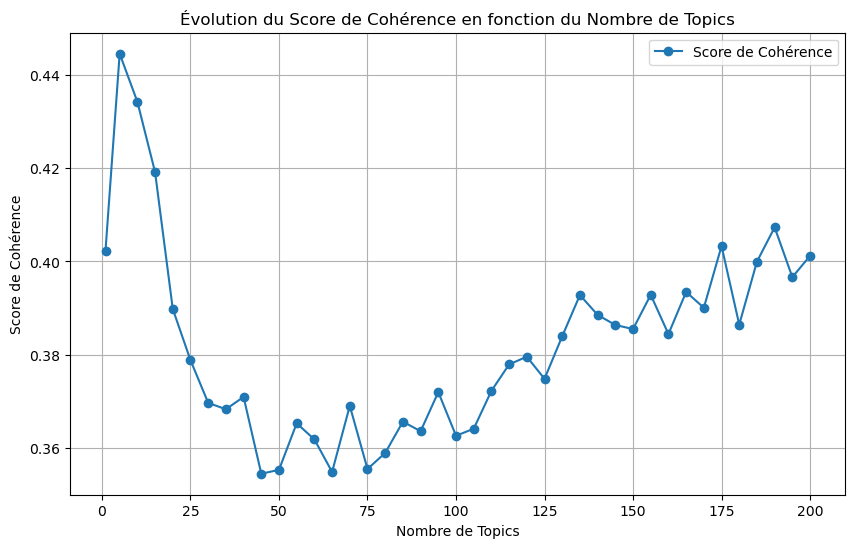

In [18]:
# Chargement des données provenant des tests réalisés (sur échantillon de 5000): 
with open('num_topics_nmf.pkl', 'rb') as fichier:
    tests_results = pickle.load(fichier)

# Réprésentation graphique des résultats : 

num_topics = list(tests_results.keys())
coherence_scores = list(tests_results.values())

# Créer un graphique à l'aide de matplotlib
plt.figure(figsize=(10, 6))  # Définir la taille du graphique (facultatif)

# Tracer la courbe des scores de cohérence
plt.plot(num_topics, coherence_scores, marker='o', linestyle='-')

# Ajouter des étiquettes et un titre
plt.xlabel('Nombre de Topics')
plt.ylabel('Score de Cohérence')
plt.title('Évolution du Score de Cohérence en fonction du Nombre de Topics')

# Afficher la légende (facultatif)
plt.legend(['Score de Cohérence'])

# Afficher le graphique
plt.grid(True)  # Activer la grille (facultatif)
plt.show()

In [19]:
num_topics_nmf = 10

debut = time.time()  # Heure de début du traitement
# Train the model on the corpus.
nmf_model = Nmf(corpus=corpus,
          id2word=id2word,
          num_topics=num_topics_nmf,
          random_state=100,
          chunksize=100,
          passes=10,
)
print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 2.48 s


- Calcul du score de cohérence de ce modèle : 

In [20]:
debut = time.time()  # Heure de début du traitement

coherence_model = CoherenceModel(model=nmf_model, texts=data['corpus'], dictionary=id2word, coherence='c_v')

coherence_score = coherence_model.get_coherence()

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f"Score de cohérence avec {nmf_model.num_topics} topics : {coherence_score:.4f}")

Durée du traitement : 7.10 s
Score de cohérence avec 10 topics : 0.4628


- Affichage des topics trouvés avec NMF

*num_words* pour choisir le nombre de mot à afficher pour chaque topic<br>
À chaque mot est associé un nombre : son importance pour le topic en question.


In [21]:
# Nombre de mots à afficher pour chaque topics
num_words = 10

topics_nmf = nmf_model.show_topics(num_topics=num_topics_nmf, num_words=num_words)

for topic in topics_nmf:
    print(topic)

(0, '0.170*"value" + 0.052*"column" + 0.022*"row" + 0.018*"number" + 0.015*"table" + 0.015*"output" + 0.013*"array" + 0.013*"string" + 0.012*"object" + 0.011*"way"')
(1, '0.178*"error" + 0.028*"project" + 0.022*"code" + 0.019*"message" + 0.016*"version" + 0.015*"c" + 0.010*"command" + 0.010*"issue" + 0.009*"use" + 0.009*"build"')
(2, '0.077*"user" + 0.037*"app" + 0.027*"page" + 0.024*"api" + 0.019*"application" + 0.018*"request" + 0.011*"component" + 0.011*"call" + 0.010*"issue" + 0.009*"way"')
(3, '0.226*"file" + 0.028*"line" + 0.019*"folder" + 0.015*"code" + 0.015*"script" + 0.013*"directory" + 0.012*"path" + 0.010*"commit" + 0.009*"content" + 0.008*"change"')
(4, '0.111*"datum" + 0.039*"server" + 0.035*"table" + 0.020*"client" + 0.019*"column" + 0.017*"query" + 0.017*"time" + 0.014*"row" + 0.014*"database" + 0.011*"api"')
(5, '0.227*"function" + 0.018*"code" + 0.016*"use" + 0.016*"call" + 0.012*"return" + 0.012*"argument" + 0.012*"loop" + 0.012*"object" + 0.011*"work" + 0.011*"way"'

- Pour chaque document, 3 mots (maximum, si possible) qui sont à la fois présents dans le document d'origine et du topic associé le plus probable. En choisissant la taille du topic avec topn=50 (donc des topics longs de 50 mots)

In [22]:
debut = time.time()  # Heure de début du traitement

# Liste pour stocker les mots du sujet les plus probables présents dans le document
top_words_in_document_nmf = []

# Parcourir les documents
for i, doc in enumerate(corpus):  # Assurez-vous que 'corpus' correspond à votre corpus de documents
    # Obtenir les probabilités d'appartenance aux topics pour ce document
    doc_topics = nmf_model.get_document_topics(doc)
    
    # Trouver le sujet le plus probable pour ce document
    most_probable_topic = max(doc_topics, key=lambda x: x[1])[0]
    
    # Obtenir les mots du sujet le plus probable
    top_words = [word for word, _ in lda_model.show_topic(most_probable_topic, topn=100)]  # topn=50 : taille (en mot) du sujet
    
    # Filtrer les mots du sujet présents dans le document
    #words_in_document = [word for word in top_words if word in data['corpus'][i]]
    words_in_document = [word for word in top_words if word in data['corpus'].iloc[i]]
    
    # Sélectionner jusqu'à trois mots du sujet présents dans le document
    selected_words = words_in_document[:3]
    
    # Ajouter les mots à la liste
    top_words_in_document_nmf.append(selected_words)

# Maintenant, 'top_words_in_document' contient jusqu'à trois mots du sujet les plus probables qui sont également présents dans chaque document




# Calculer le pourcentage de listes vides dans top_words_in_document
empty_lists_count = sum(1 for words in top_words_in_document_nmf if not words)
total_lists = len(top_words_in_document_nmf)
percentage_empty_lists = (empty_lists_count / total_lists) * 100

# Afficher le pourcentage
print(f"Pourcentage de listes vides : {percentage_empty_lists:.2f}%")


print(f"Durée du traitement : {(time.time() - debut):.2f} s")


print("Pour les 10 premiers document : ")
display(top_words_in_document_nmf[:10])



Pourcentage de listes vides : 85.00%
Durée du traitement : 12.84 s
Pour les 10 premiers document : 


[[], [], [], [], [], [], [], [], [], []]

- Création de la colonne *NMF_predicted_tags* dans notre dataset : 

In [23]:
data['NMF_predicted_tags'] = top_words_in_document_nmf
data

,corpus,tags,LDA_predicted_tags,NMF_predicted_tags
35187,"[blazor, server, invalidoperationexception, fa...","[c#, blazor]","[template, resolve, stack]",[]
31775,"[user, consent, prompt, scope, permission, out...",[azure],"[user, app, login]",[]
17244,"[file, client, side, backend, load, user, file...","[express, javascript, vue.js, node.js]","[file, backend, drive]",[]
43793,"[part, condition, follow, question, post, repl...","[r, dplyr]","[column, group]",[]
3278,"[service, background, version, docker, questio...",[kubernetes],"[process, thread, info]",[]
...,...,...,...,...
38843,"[workaround, map, type, function, question, gi...",[typescript],"[type, object]",[]
34350,"[powershell, difference, object, behavior, arr...",[powershell],[string],[]
3822,"[column, calculation, day, date, column, objec...","[date, pandas, string, python]",[value],[]
30827,"[connection, reset, peer, error, server, load,...",[rust],"[code, example]",[]


- Pourcentage de cas où il y a au moins un tag en commun entre les tags réels et les tags prédits par NMF : 

In [24]:
# Initialiser un compteur pour les cas où il y a au moins un mot en commun
common_word_count = 0

# Parcourir les lignes du dataframe
for index, row in data.iterrows():
    # Obtenir les valeurs des colonnes 'NMF_predicted_tags' et 'tags' pour cette ligne
    nmf_tags = set(row['NMF_predicted_tags'])
    real_tags = set(row['tags'])    
    
    # Vérifier s'il y a au moins un mot en commun entre les ensembles
    if nmf_tags & real_tags:  # "nmf_tags & real_tags" retourne un set contenant les valeurs communes entre les deux, ou un set vide si aucune valeur commune.
        common_word_count += 1  # si le set retourné n'est pas vide, qu'il existe, alors incrémenter common_word_count de 1 (= il y a eu un cas où il y avait un mot en commun)

# Calculer le pourcentage de cas où il y a au moins un mot en commun
total_cases = len(data)
percentage_common_word_cases = (common_word_count / total_cases) * 100

# Afficher le résultat
print(f"Pourcentage de cas avec au moins un mot en commun entre les tags réels et les tags prédits par NMF : {percentage_common_word_cases:.2f}%")

Pourcentage de cas avec au moins un mot en commun entre les tags réels et les tags prédits par NMF : 0.56%


- Mesure de la durée d'exécution du notebook : 

In [25]:
temps_secondes = time.time() - t_notebook

# Conversion en minutes et secondes
minutes = int(temps_secondes // 60)
seconds = int(temps_secondes % 60)

# Formatage du résultat
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Durée d'exécution du notebook (hors imports) : {formatted_time}")

Durée d'exécution du notebook (hors imports) : 01:22
